# Recommendation Systems Project

Mate Balogh

E28H7B

**Item** recommendations for **visitors** in an online store based on *implicit feedback* to provide better user experience and to boost sales.

## Setup

In [34]:
!pip install cornac adjustText --quiet

In [35]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cornac
import itertools
import seaborn as sns

from cornac.eval_methods import RatioSplit
from cornac.metrics import Precision, Recall
from cornac.models import WMF
from adjustText import adjust_text
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
RAND = 10

In [37]:
#@title ### Helpers
def get_idx(ids, collection):
    return list(map(lambda x: collection.index.get_loc(x), ids))

In [38]:
#@title ### Download dataset
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ecommerce-dataset


## Dataset

In [39]:
events = pd.read_csv(path + "/events.csv",
                     dtype={'timestamp': int, 'visitorid': int, 'itemid': int, 'event': 'string', 'transactionid': object})

## Exploratory Data Analysis

In [40]:
events.shape

(2756101, 5)

In [41]:
events.columns.to_list()

['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

In [42]:
events.head(n=3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


In [43]:
events.isna().any()

,0
timestamp,False
visitorid,False
event,False
itemid,False
transactionid,True


In [44]:
events.describe()

,timestamp,visitorid,itemid
count,2.756101e+06,2.756101e+06,2.756101e+06
mean,1.436424e+12,7.019229e+05,2.349225e+05
std,3.366312e+09,4.056875e+05,1.341954e+05
min,1.430622e+12,0.000000e+00,3.000000e+00
25%,1.433478e+12,3.505660e+05,1.181200e+05
50%,1.436453e+12,7.020600e+05,2.360670e+05
75%,1.439225e+12,1.053437e+06,3.507150e+05
max,1.442545e+12,1.407579e+06,4.668670e+05


In [45]:
print("# of visitors in 'events':", events['visitorid'].count(), "among which", events['visitorid'].nunique(), "is unique.")
print("# of items in 'events':", events['itemid'].count(), "among which", events['itemid'].nunique(), "is unique.")
print("# of event in 'events':", events['event'].count(), "among which", events['event'].nunique(), "is unique.")
print("# of transactions in 'events':", events['transactionid'].count(), "among which", events['transactionid'].nunique(), "is unique.")

# of visitors in 'events': 2756101 among which 1407580 is unique.
# of items in 'events': 2756101 among which 235061 is unique.
# of event in 'events': 2756101 among which 3 is unique.
# of transactions in 'events': 22457 among which 17672 is unique.


In [46]:
events.sort_values(by=['transactionid'], ascending=False)

,timestamp,visitorid,event,itemid,transactionid
1113712,1440787093666,1283849,transaction,459615,9999
2372854,1437093851492,530559,transaction,357519,9998
1772020,1431999053822,55389,transaction,412516,9997
1478628,1430669157237,1390702,transaction,86218,9996
2090520,1435854317206,271719,transaction,238386,9995
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


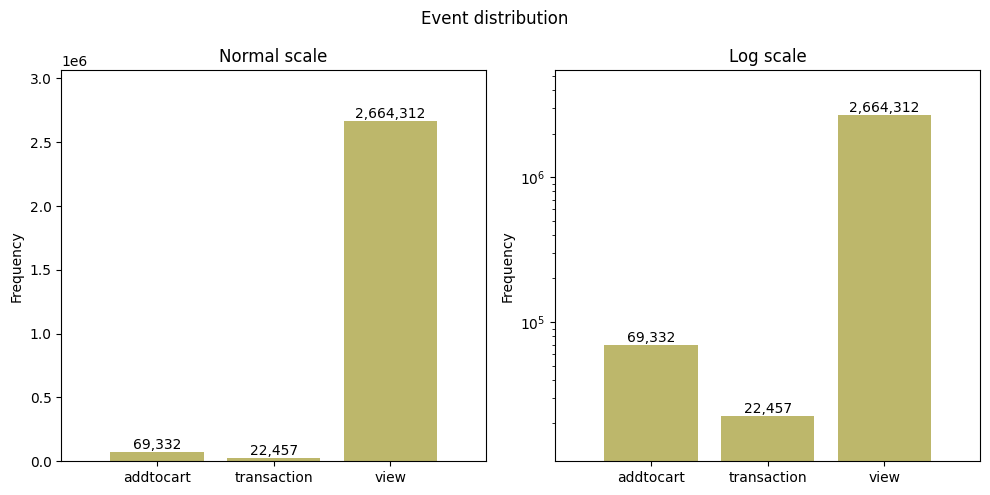

In [47]:
#@title #### Event frequency distribution

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

events_freqdist = events.groupby('event')['event'].count()

def plot_on_ax(_ax):
    fd = _ax.bar(events_freqdist.index, events_freqdist.values, color="darkkhaki")
    _ax.bar_label(fd, fmt="{:,.0f}")

ax = axes[0]
plot_on_ax(ax)
ax.set_title("Normal scale")

ax = axes[1]
plot_on_ax(ax)
ax.set_yscale('log')
ax.set_title("Log scale")

for ax in axes:
    ax.set_ylabel('Frequency')
    ax.margins(.15)

plt.suptitle('Event distribution')
plt.tight_layout()
plt.show()

del plot_on_ax

### Transaction events

In [48]:
condTransaction = events['event'] == 'transaction'
transaction_events = events[condTransaction]

print("`transaction_events` shape:", transaction_events.shape)
assert transaction_events['transactionid'].notna().all()

`transaction_events` shape: (22457, 5)


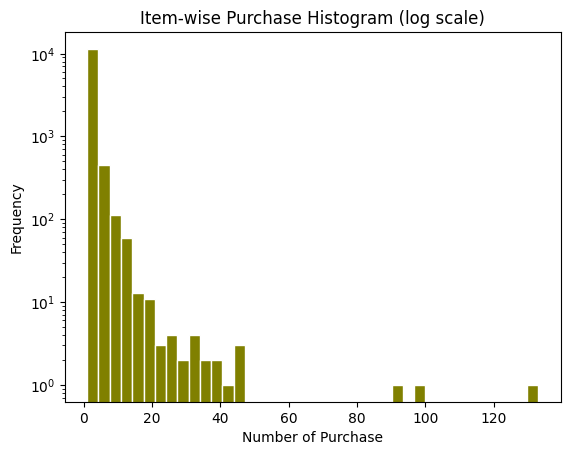

In [49]:
plt.hist(transaction_events.groupby(by='itemid')['transactionid'].count().reset_index(drop=True),
         bins=40, edgecolor="white", color="olive")

plt.title("Item-wise Purchase Histogram (log scale)")
plt.xlabel("Number of Purchase")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

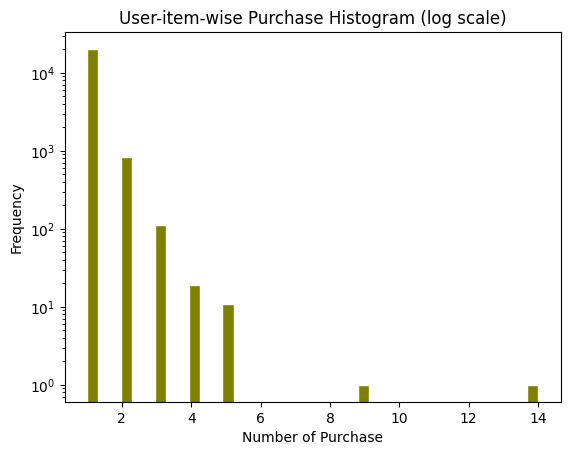

In [50]:
plt.hist(transaction_events.groupby(by=['visitorid', 'itemid'])['transactionid'].count().reset_index(drop=True),
         bins=40, edgecolor="white", color="olive")

plt.title("User-item-wise Purchase Histogram (log scale)")
plt.xlabel("Number of Purchase")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

# Implementations

In [51]:
# designated user
designated_visitor_id = 71586
condDesignatedVisitor = transaction_events['visitorid'] == designated_visitor_id
assert transaction_events[condDesignatedVisitor]['itemid'].count() > 0

In [52]:
K = 100
N = 5

## `PopularItemRecommender`

In [53]:
class PopularItemRecommender():
    def __init__(self, transactions, verb=False):
        self.transactions = transactions
        self.verb = verb

        if self.verb:
            self.welcome()

    def welcome(self):
        print("Popular Item Recommender", "\n")

    def recommend(self, n):
        items_recommended = (
            self.transactions.groupby(by='itemid')['transactionid']
            .count()
            .sort_values(ascending=False)[:n]
            .index
            .tolist()
        )

        if self.verb:
            print("Recommended items:", "\n")
            display(pd.Series(items_recommended, name="itemid").to_frame().T)

        return items_recommended

In [54]:
items_recommended = (
    PopularItemRecommender(transaction_events, verb=True)
        .recommend(N)
)

Popular Item Recommender 

Recommended items: 



,0,1,2,3,4
itemid,461686,119736,213834,7943,312728


### Explanation

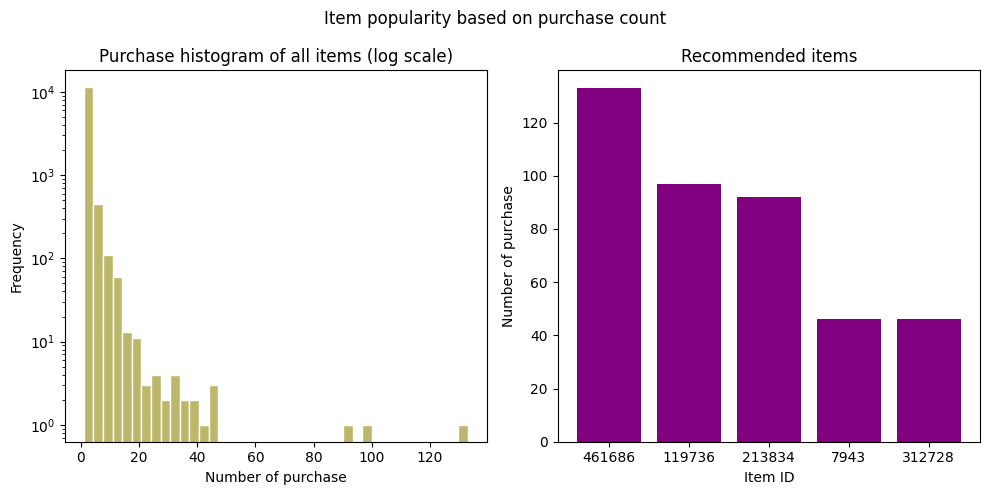

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 0
ax = axes[0]
df = transaction_events.groupby(by='itemid')['transactionid'].count()
ax.hist(df, bins=40, edgecolor="white", color="darkkhaki")

ax.set_title("Purchase histogram of all items (log scale)")
ax.set_xlabel("Number of purchase")
ax.set_ylabel("Frequency")
ax.set_yscale('log')

# 1
ax = axes[1]
df = (transaction_events
    .pipe(lambda df: df[df['itemid'].isin(items_recommended)])
    .pipe(lambda df: df.groupby(by='itemid')['transactionid'].count())
    .rename('purchase count')
    .sort_values(ascending=False)
    .reset_index()
)

ax.bar(df['itemid'].astype(str), df['purchase count'], color="purple")

ax.set_xlabel("Item ID")
ax.set_ylabel("Number of purchase")
ax.set_title("Recommended items")

plt.suptitle('Item popularity based on purchase count')
plt.tight_layout()
plt.show()

## `MeanPopularItemRecommender`

In [56]:
class MeanPopularItemRecommender():
    def __init__(self, transactions, verb=False):
        self.transactions = transactions
        self.verb = verb

        if self.verb:
            self.welcome()

    def welcome(self):
        print("Mean Popular Item Recommender", "\n")

    def recommend(self, n):
        items_recommended = (
            self.transactions
            .pipe(lambda df: df.groupby(by=['visitorid', 'itemid'])['transactionid'].count().rename("visitor purchase count"))
            .reset_index()
            .pipe(lambda df: df.groupby(by='itemid')['visitor purchase count'].mean())
            .sort_values(ascending=False)[:n]
            .index
            .tolist()
        )

        if self.verb:
            print("Recommended items:", "\n")
            display(pd.Series(items_recommended, name="itemid").to_frame().T)

        return items_recommended

In [57]:
items_recommended = (
    MeanPopularItemRecommender(transaction_events, verb=True)
        .recommend(N)
)

Mean Popular Item Recommender 

Recommended items: 



,0,1,2,3,4
itemid,396042,224549,147,218612,347641


### Explanation

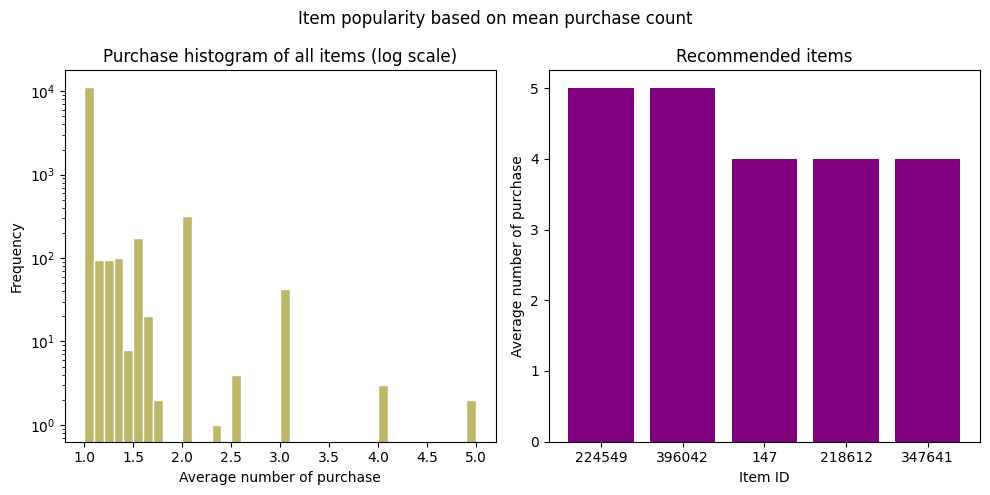

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 0
ax = axes[0]
df = (transaction_events
    .pipe(lambda df: df.groupby(by=['visitorid', 'itemid'])['transactionid'].count().rename("visitor purchase count"))
    .reset_index()
    .pipe(lambda df: df.groupby(by='itemid')['visitor purchase count'].mean()))
ax.hist(df, bins=40, edgecolor="white", color="darkkhaki")

ax.set_title("Purchase histogram of all items (log scale)")
ax.set_xlabel("Average number of purchase")
ax.set_ylabel("Frequency")
ax.set_yscale('log')

# 1
ax = axes[1]
df = (transaction_events
    .pipe(lambda df: df[df['itemid'].isin(items_recommended)])
    .pipe(lambda df: df.groupby(by=['visitorid', 'itemid'])['transactionid'].count().rename("visitor purchase count"))
    .reset_index()
    .pipe(lambda df: df.groupby(by='itemid')['visitor purchase count'].mean())
    .rename('mean purchase count')
    .sort_values(ascending=False)
    .reset_index()
)

ax.bar(df['itemid'].astype(str), df['mean purchase count'], color="purple")

ax.set_xlabel("Item ID")
ax.set_ylabel("Average number of purchase")
ax.set_title("Recommended items")

plt.suptitle('Item popularity based on mean purchase count')
plt.tight_layout()
plt.show()

## `UserBasedCollabFilterItemRecommender`

In [ ]:
visitor_item_pivot = transaction_events.pivot_table(index='visitorid', columns='itemid', values='event', aggfunc='any').fillna(0).astype(int)
visitor_item_pivot
assert visitor_item_pivot.sum().sum() == transaction_events.groupby(by=['visitorid', 'itemid'])['itemid'].count().reset_index(drop=True).count()

In [ ]:
visitor_item_similarity = cosine_similarity(visitor_item_pivot)
visitor_item_similarity

In [ ]:
(visitor_item_pivot.shape, visitor_item_similarity.shape)

In [ ]:
visitor_loc = visitor_item_pivot.index.get_loc(designated_visitor_id)
selected_visitor_pivot = visitor_item_pivot.iloc[visitor_loc, :]
selected_visitor_similarity = visitor_item_similarity[visitor_loc, :]

In [ ]:
class UserBasedCollabFilterItemRecommender():
    def __init__(self, pivot, similarity):
        self.pivot = pivot
        self.similarity = similarity

        self.fitted = False
        self.recommended = False

        self.welcome()

    def welcome(self):
        print("User-based Collaborative Filter Item Recommender")

    def fit(self, userid):
        self.userid = userid
        self.user_loc = self.pivot.index.get_loc(self.userid)
        self.user_pivot = self.pivot.iloc[self.user_loc, :]
        self.user_similarity = self.similarity[self.user_loc, :]

        interacted_mask = self.user_pivot[self.user_pivot.gt(0)]
        interacted_itemids = interacted_mask.index

        print("Item # already interacted with:\n\n", interacted_itemids.to_list(), "\n\n")
        self.interacted_itemids = interacted_itemids
        self.fitted = True

    def recommend(self, k, n):
        self.k = k
        self.n = n

        similar_user_locs = self.user_similarity.argpartition(-(k+1))[-(k+1):]

        if np.isin(similar_user_locs, self.user_loc).any():
            similar_user_locs = similar_user_locs[similar_user_locs != self.user_loc]

        similar_user_locs = similar_user_locs[self.user_similarity[similar_user_locs] >= 0.1]
        similar_userids = self.pivot.iloc[similar_user_locs].index

        print(f"K={self.k} most similar user #:\n\n", similar_userids.to_list(), "\n\n")

        assert np.invert(np.isin(self.user_loc, similar_user_locs))
        #assert (len(similar_user_locs) > (k/2)) & (len(similar_user_locs) <= k)

        # recommendation
        items_recommended = (self.pivot.iloc[similar_user_locs]
                                           .sum(axis=0)
                                           .astype('int')
                                           .rename('Transaction frequency')
                                           .where(lambda x: x > 0)
                                           .where(lambda x: np.invert(np.isin(x.index, self.interacted_itemids)))
                                           .dropna()
                                           .sort_values(ascending=False)[:self.n]
                                           .astype('int')
                            )
        assert (~np.isin(self.interacted_itemids, items_recommended)).all()
        assert len(items_recommended) <= self.n

        self.recommended = True
        self.similar_userids = similar_userids
        self.items_recommended = items_recommended

        print("Recommended items:", "\n")
        display(pd.Series(items_recommended.index.tolist(), name="itemid").to_frame().T)
        return items_recommended

    def get_fit_memory(self):
        assert self.fitted, "Model not fitted. Call .fit() first."
        assert self.interacted_itemids is not None
        return {
            'userid': self.userid,
            'interacted_itemids': self.interacted_itemids.to_list()
        }

    def get_recommend_memory(self):
        assert self.recommended, "Model has no recommendation memory. Call .recommend() first."
        assert self.similar_userids is not None
        assert self.items_recommended is not None
        return {
            'similar_userids': self.similar_userids.to_list(),
            'items_recommended': self.items_recommended.index.to_list(),
            'k': self.k,
            'n': self.n
        }

In [ ]:
model = UserBasedCollabFilterItemRecommender(visitor_item_pivot, visitor_item_similarity)
model.fit(designated_visitor_id)
recommendation = model.recommend(K, N)

### Explanation

In [ ]:
fit_memory = model.get_fit_memory()
recommend_memory = model.get_recommend_memory()

In [ ]:
class UserBasedCFRVerifier():
    def __init__(self, model):
        self.model = model

    def run(self, designated_visitor_id):
        fm = self.model.get_fit_memory()
        rm = self.model.get_recommend_memory()

        # designater user
        assert designated_visitor_id == fm['userid']
        # interacted items
        df = transaction_events[transaction_events['visitorid'] == designated_visitor_id]
        assert (df['itemid'].nunique() == len(fm['interacted_itemids']))
        # similar users
        assert len(rm['similar_userids']) <= rm['k']
        assert np.invert(np.isin(designated_visitor_id, rm['similar_userids']))
        # recommended items
        assert np.invert(np.isin(fm['interacted_itemids'], rm['items_recommended'])).all()
        assert len(rm['items_recommended']) <= rm['n']

In [ ]:
UserBasedCFRVerifier(model).run(designated_visitor_id)

In [ ]:
# designated user
display((designated_visitor_id, visitor_item_pivot.index.get_loc(designated_visitor_id)))

In [ ]:
# interacted items
print("Interacted itemids (acc. to model): ", fit_memory['interacted_itemids'])
print("Transaction records (history):")
display(transaction_events[condDesignatedVisitor])

In [ ]:
# similar users
print(f"{recommend_memory['k']} similar userids (acc. to model): ", recommend_memory['similar_userids'])

# recommended items
print(f"{recommend_memory['n']} recommended items (acc. to model): ", recommend_memory['items_recommended'])

In [ ]:
(transaction_events[transaction_events['visitorid'].isin(recommend_memory['similar_userids'])]
    .groupby(by=['visitorid', 'itemid'])[['transactionid']]
    .count())

In [ ]:
# similarity of selected users
df = visitor_item_similarity[
    get_idx([designated_visitor_id], visitor_item_pivot),
    get_idx(recommend_memory['similar_userids'], visitor_item_pivot)
]

display(len(df))
display(df)

In [ ]:
df = visitor_item_pivot.iloc[get_idx(recommend_memory['similar_userids'], visitor_item_pivot)]

df[df > 0].stack().index.get_level_values(1).value_counts()